# Florida Current and Virginia Key Tide

#  Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import figure, show, legend, ylabel
import json
import urllib.request
from urllib.request import urlopen
from pprint import pprint
import pandas as pd
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
import matplotlib.dates as dl
import datetime
from datetime import date, timedelta

# Download Florida Current data

In [2]:
url='https://www.aoml.noaa.gov/phod/floridacurrent/FC_cable_transport_2021.dat'
current=np.loadtxt(url,skiprows=22,usecols=(0,1,2,3))
d1 = pd.DataFrame(current,columns=['year','month','day','transport']) # converts from 4 columns to pandas data frame
d3 = {'year':'year','month':'month','day':'day'}
d1['date'] = pd.to_datetime(d1.rename(columns=d3)[list(d3.values())]) # creates date from year, month and day
print(d1.columns)
print(d1.tail())


Index(['year', 'month', 'day', 'transport', 'date'], dtype='object')
       year  month  day  transport       date
243  2021.0    9.0  1.0       32.2 2021-09-01
244  2021.0    9.0  2.0       33.4 2021-09-02
245  2021.0    9.0  3.0       34.1 2021-09-03
246  2021.0    9.0  4.0       33.2 2021-09-04
247  2021.0    9.0  5.0       32.4 2021-09-05


# Download Viginia Key predicted and observed tide
# Estimate daily average from hourly data

In [3]:
websource = urllib.request.urlopen('https://tidesandcurrents.noaa.gov/api/datagetter?product=predictions'+\
                                   '&application=NOS.COOPS.TAC.WL&begin_date=20210101&end_date=20211231&datum=NAVD'+\
                                   '&station=8723214&time_zone=lst_ldt&units=english&interval=h&format=json')
predictions = json.loads(websource.read().decode())
#pprint(predictions)
dates_pred = [i['t'] for i in predictions["predictions"]] # extracts only time 't'
dates_pred=np.array(dates_pred, dtype='datetime64')
values_pred = [i['v'] for i in predictions['predictions']] #extracts only value 'v'
pred = {'date':dates_pred,'prediction':values_pred}
pred_df = pd.DataFrame(pred)
pred_df['year'] = pd.DatetimeIndex(pred_df['date']).year
pred_df['month'] = pd.DatetimeIndex(pred_df['date']).month
pred_df['day'] = pd.DatetimeIndex(pred_df['date']).dayofyear
pred_df['prediction'] = pd.to_numeric(pred_df['prediction'], errors ='coerce')
g_day = pred_df.groupby(['year', 'month','day'])
daily_mean_pred = g_day.aggregate({'prediction':np.mean})
daily_mean_pred = daily_mean_pred.reset_index()
#print (daily_mean_pred.reset_index())

websource1 = urllib.request.urlopen('https://tidesandcurrents.noaa.gov/api/datagetter?begin_date=20210101' + \
                                    '&end_date=20211231&station=8723214&product=hourly_height&datum=NAVD&units=english' + \
                                    '&time_zone=lst_ldt&interval=h&application=NOS.COOPS.TAC.WL&format=json')
observations = json.loads(websource1.read().decode())
dates_obs = [i['t'] for i in observations["data"]]
dates_obs = np.array(dates_obs, dtype='datetime64')
values_obs = [i['v'] for i in observations['data']]
obs = {'date':dates_obs,'observed':values_obs}
obs_df = pd.DataFrame(obs)
obs_df['year'] = pd.DatetimeIndex(obs_df['date']).year
obs_df['month'] = pd.DatetimeIndex(obs_df['date']).month
obs_df['day'] = pd.DatetimeIndex(obs_df['date']).dayofyear
obs_df['observed'] = pd.to_numeric(obs_df['observed'], errors ='coerce')
 
g_day1 = obs_df.groupby(['year', 'month','day'])
daily_mean_obs = g_day1.aggregate({'observed':np.mean})
daily_mean_obs = daily_mean_obs.reset_index()
print(json.dumps(dict(websource1.headers)))
print(daily_mean_pred.tail())
print(daily_mean_obs.tail())

{"Date": "Sun, 26 Sep 2021 17:28:29 GMT", "Content-Type": "application/json;charset=ISO-8859-1", "Content-Length": "365837", "Connection": "close", "x-amzn-RequestId": "b62e0c4e-7bdd-4d08-9f79-9b5a651412d3", "Access-Control-Allow-Origin": "*", "Access-Control-Allow-Headers": "X-Requested-With", "x-amzn-Remapped-Connection": "keep-alive", "x-amz-apigw-id": "GSAVtF18IAMFRZg=", "Cache-Control": "no-cache,no-store,must-revalidate", "x-amzn-Remapped-Server": "nginx/1.20.0", "Expires": "Thu, 01 Jan 1970 00:00:00 GMT", "Pragma": "no-cache", "x-amzn-Remapped-Date": "Sun, 26 Sep 2021 17:27:56 GMT"}
     year  month  day  prediction
360  2021     12  361   -1.006417
361  2021     12  362   -0.992750
362  2021     12  363   -0.978625
363  2021     12  364   -0.972625
364  2021     12  365   -0.983292
     year  month  day  observed
238  2021      8  239 -0.256833
239  2021      8  240 -0.250250
240  2021      8  241 -0.426583
241  2021      8  242 -0.534542
242  2021      8  243 -0.374550


# Preliminary observed data

In [4]:
today = date.today() + timedelta(1)
end_date = str(today.strftime("%Y%m%d"))
start = date.today() - timedelta(25)
start_date = str(start.strftime("%Y%m%d"))
print("Start date:", start_date)
print("End date:", end_date)
url= ('https://tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={}'+\
      '&end_date={}&station=8723214&datum=NAVD&product=water_level&units=english'+
      '&time_zone=lst&interval=h&application=NOS.COOPS.TAC.WL&format=json').format(start_date,end_date)
websource2 = urllib.request.urlopen(url)
wl_site = json.loads(websource2.read().decode())
dates_wl = [i['t'] for i in wl_site["data"]]
dates_wl = np.array(dates_wl, dtype='datetime64')
values_wl = [i['v'] for i in wl_site['data']]
wl = {'date':dates_wl,'observed':values_wl}
wl_df = pd.DataFrame(wl)
wl_df['year'] = pd.DatetimeIndex(wl_df['date']).year
wl_df['month'] = pd.DatetimeIndex(wl_df['date']).month
wl_df['day'] = pd.DatetimeIndex(wl_df['date']).dayofyear
wl_df['observed'] = pd.to_numeric(wl_df['observed'], errors ='coerce')
wl_df['water_level'] = wl_df['observed']
g_day2 = wl_df.groupby(['year', 'month','day'])
daily_mean_wl = g_day2.aggregate({'water_level':np.mean})
daily_mean_wl = daily_mean_wl.reset_index()
print(json.dumps(dict(websource2.headers)))
#print(wl_site)
print(daily_mean_wl)

Start date: 20210901
End date: 20210927
{"Date": "Sun, 26 Sep 2021 17:28:30 GMT", "Content-Type": "application/json;charset=ISO-8859-1", "Content-Length": "462846", "Connection": "close", "x-amzn-RequestId": "8193833f-2b97-40f4-bfe6-78159de1f3b2", "Access-Control-Allow-Origin": "*", "Access-Control-Allow-Headers": "X-Requested-With", "x-amzn-Remapped-Connection": "keep-alive", "x-amz-apigw-id": "GSAV0G94oAMF0oQ=", "Cache-Control": "no-cache,no-store,must-revalidate", "x-amzn-Remapped-Server": "nginx/1.20.0", "Expires": "Thu, 01 Jan 1970 00:00:00 GMT", "Pragma": "no-cache", "x-amzn-Remapped-Date": "Sun, 26 Sep 2021 17:28:30 GMT"}
    year  month  day  water_level
0   2021      9  244    -0.468821
1   2021      9  245    -0.539017
2   2021      9  246    -0.681867
3   2021      9  247    -0.675796
4   2021      9  248    -0.582214
5   2021      9  249    -0.510350
6   2021      9  250    -0.276908
7   2021      9  251    -0.241188
8   2021      9  252    -0.187646
9   2021      9  253   

# Estimate tide residuals

In [5]:
tide1 = daily_mean_pred.merge(daily_mean_obs, how='left', on=['year','month','day'])
tide = tide1.merge(daily_mean_wl, how='left', on=['year','month','day'])
tide['residuals'] = tide['observed'] - tide['prediction']
tide['residuals_prelim'] = tide['water_level'] - tide['prediction']
tide['day'] = pd.to_datetime(tide['day'], format='%j').dt.strftime('%d')
d3 = {'year':'year','month':'month','day':'day'}
tide['date'] = pd.to_datetime(tide.rename(columns=d3)[list(d3.values())])
#tide = tide[tide['residuals'].notna()]
tide = tide.dropna(subset=['residuals', 'residuals_prelim'], how='all')
print(tide.columns)
print(tide)

Index(['year', 'month', 'day', 'prediction', 'observed', 'water_level',
       'residuals', 'residuals_prelim', 'date'],
      dtype='object')
     year  month day  prediction  observed  water_level  residuals  \
0    2021      1  01   -1.070500 -0.998333          NaN   0.072167   
1    2021      1  02   -1.089625 -1.175333          NaN  -0.085708   
2    2021      1  03   -1.102458 -1.289208          NaN  -0.186750   
3    2021      1  04   -1.107917 -1.240958          NaN  -0.133042   
4    2021      1  05   -1.104583 -1.099458          NaN   0.005125   
..    ...    ...  ..         ...       ...          ...        ...   
264  2021      9  22   -0.543083       NaN    -0.165421        NaN   
265  2021      9  23   -0.538417       NaN    -0.039900        NaN   
266  2021      9  24   -0.529042       NaN    -0.126725        NaN   
267  2021      9  25   -0.517542       NaN    -0.212504        NaN   
268  2021      9  26   -0.506667       NaN    -0.251621        NaN   

     residuals_p

# Plot predicted and observed tide at Virginia Key

C:\Users\Martina\AppData\Local\Continuum\Anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


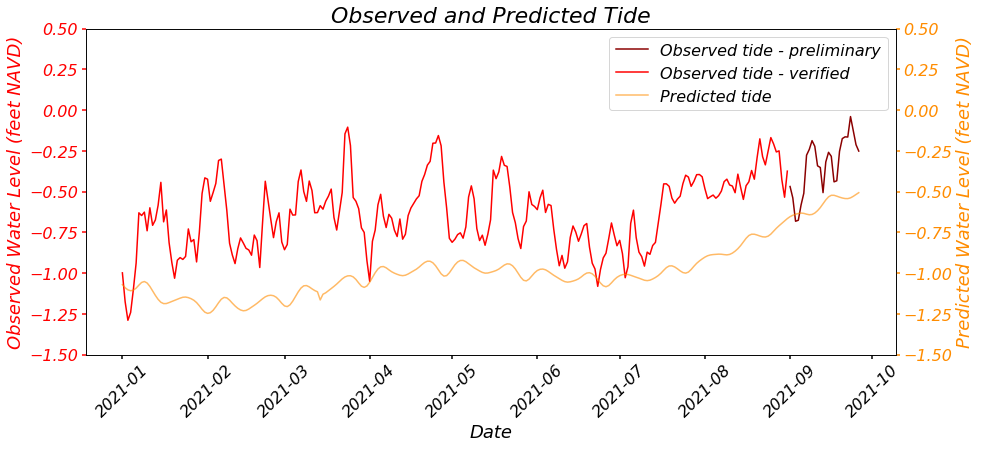

In [6]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
fig.subplots_adjust(right=0.75)

ax1 = ax.twinx()
p1, = ax.plot(tide['date'], tide['water_level'], color='darkred', label="Observed tide - preliminary")
p2, = ax.plot(tide['date'], tide['observed'], color='red', label="Observed tide - verified")
p3, = ax1.plot(tide['date'], tide['prediction'], 'darkorange', alpha=0.6, label="Predicted tide")

ax.set_xlabel("Date", fontsize= 18)
ax.set_ylabel("Observed Water Level (feet NAVD)", fontsize= 18)
ax1.set_ylabel("Predicted Water Level (feet NAVD)", fontsize= 18)
ax1.set_title('Observed and Predicted Tide', fontsize=22)
ax.set_ylim([-1.5,0.5])
ax1.set_ylim([-1.5,0.5])

ax.yaxis.label.set_color(p2.get_color())
ax1.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p2.get_color(), **tkw,labelsize = 16)
ax1.tick_params(axis='y', colors=p3.get_color(), **tkw,labelsize = 16)
ax.tick_params(axis='x', **tkw, rotation=45,labelsize = 16)

lines = [p1, p2,p3]
ax.legend(lines, [l.get_label() for l in lines], fontsize = 16)

plt.show()

# Plot Tide Residuals

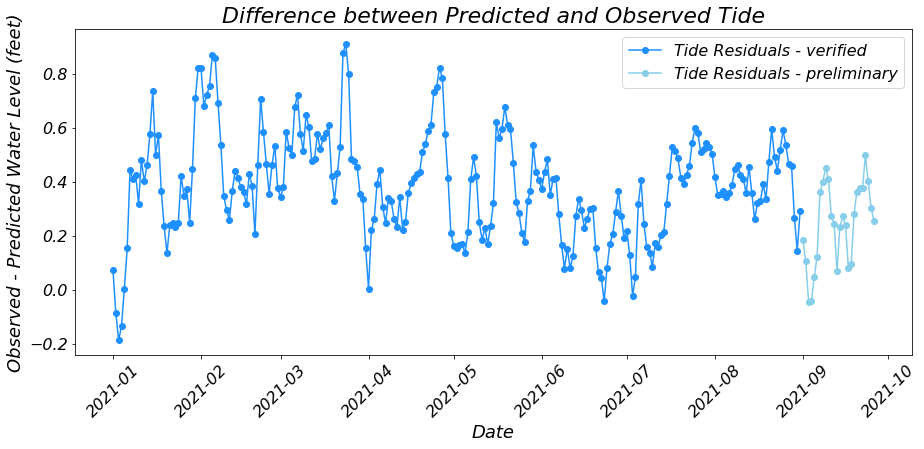

In [10]:
fig = plt.figure(figsize=(15,6))
plt.plot(tide['date'], tide['residuals'],'-o', color='dodgerblue', label='Tide Residuals - verified')
plt.plot(tide['date'], tide['residuals_prelim'],'-o', color='skyblue', label='Tide Residuals - preliminary')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Observed - Predicted Water Level (feet)", fontsize=18)
plt.title("Difference between Predicted and Observed Tide", fontsize=22)
plt.legend(loc='upper right',fontsize=16)

# Plot Florida Current

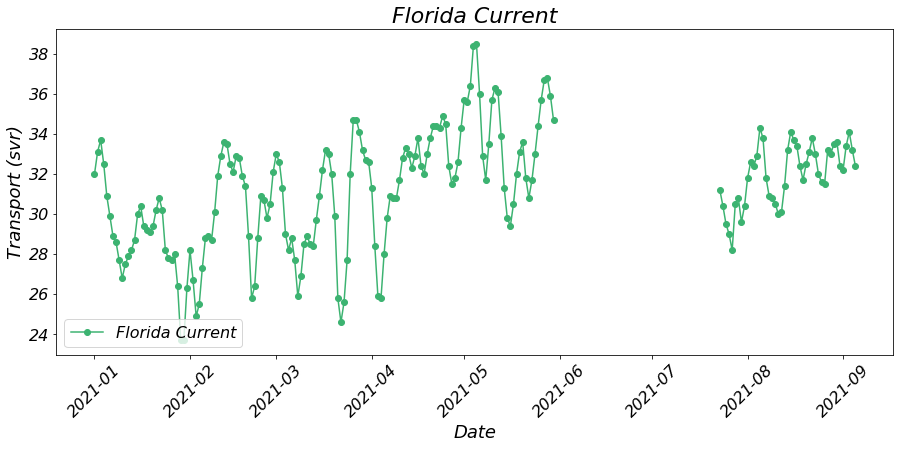

In [8]:
fig = plt.figure(figsize=(15,6))
plt.plot(d1['date'],d1['transport'],'o-', color='mediumseagreen')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Transport (svr)", fontsize=18)
plt.title("Florida Current", fontsize=22)
plt.legend(['Florida Current'],loc='lower left',fontsize=16)

# Plot Florida Current and Tide Residuals

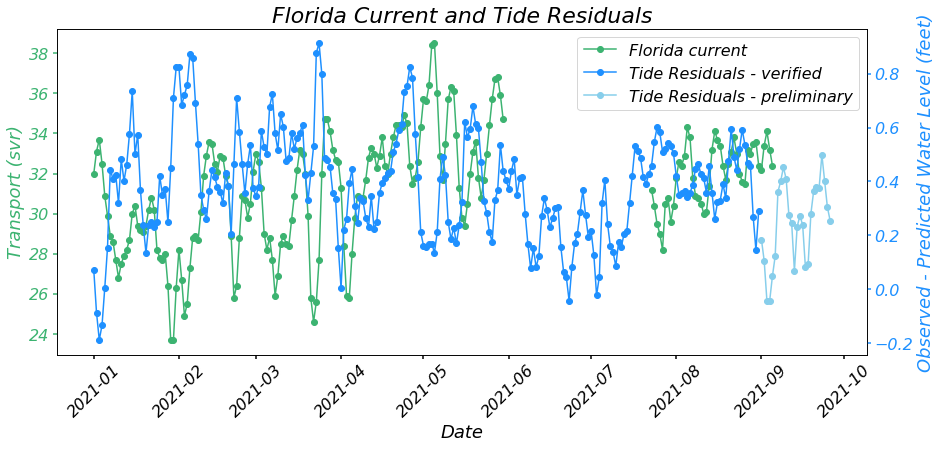

In [9]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
fig.subplots_adjust(right=0.75)

ax1 = ax.twinx()
p1, = ax.plot(d1['date'],d1['transport'], 'o-', color='mediumseagreen', label="Florida current")
p2, = ax1.plot(tide['date'], tide['residuals'],'-o', color='dodgerblue', label="Tide Residuals - verified")
p3, = ax1.plot(tide['date'], tide['residuals_prelim'],'-o', color='skyblue', label="Tide Residuals - preliminary")

ax.set_xlabel("Date", fontsize= 18)
ax.set_ylabel("Transport (svr)", fontsize= 18)
ax1.set_ylabel("Observed - Predicted Water Level (feet)", fontsize= 18)
ax1.set_title('Florida Current and Tide Residuals', fontsize=22)

ax.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw,labelsize = 16)
ax1.tick_params(axis='y', colors=p2.get_color(), **tkw,labelsize = 16)
ax.tick_params(axis='x', **tkw, rotation=45,labelsize = 16)

lines = [p1, p2,p3]
ax.legend(lines, [l.get_label() for l in lines], fontsize = 16)

plt.show()